Fit an exact GP to a medium number of samples of the Branin function.

In [1]:
from itertools import product
import numpy as np
import torch

def branin(X):
    x_1 = X[:, 0]
    x_2 = X[:, 1]
    return (
        (x_2 - 5.1 / (4 * np.pi ** 2) * x_1 ** 2 + 5.0 / np.pi * x_1 - 6.0) ** 2
        + 10 * (1 - 1.0 / (8 * np.pi)) * torch.cos(x_1)
        + 10
    )

x_grid = [-5, -2, 0, 2, 5, 10]
y_grid = [0, 3, 6, 9, 12, 15]
X = torch.Tensor(list(product(x_grid, y_grid)))
Y = branin(X)

In [2]:
import gpytorch

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

A function for optimizing a model with Adam, and another for L-BFGS.

In [3]:
# Fit with a Torch optimizer (Adam)

import time
from typing import Any, Dict, List, Optional, NamedTuple, Tuple

from gpytorch.mlls.marginal_log_likelihood import MarginalLogLikelihood
from gpytorch.module import Module
from scipy.optimize import minimize
from torch import Tensor
from torch.optim.adam import Adam
from torch.optim.optimizer import Optimizer


class OptimizationIteration(NamedTuple):
    itr: int
    fun: float
    time: float


def fit_torch(
    mll: MarginalLogLikelihood,
    optimizer_cls: Optimizer = Adam,
    lr: float = 0.05,
    maxiter: int = 100,
    optimizer_args: Optional[Dict[str, float]] = None,
    disp: bool = True,
    track_iterations: bool = True,
) -> Tuple[MarginalLogLikelihood, List[OptimizationIteration]]:
    """Fit a gpytorch model by maximizing MLL with a torch optimizer.

    The model and likelihood in mll must already be in train mode.

    Args:
        mll: MarginalLogLikelihood to be maximized.
        optimizer_cls: Torch optimizer to use. Must not need a closure.
            Defaults to Adam.
        lr: Starting learning rate.
        maxiter: Maximum number of iterations.
        optimizer_args: Additional arguments to instantiate optimizer_cls.
        disp: Print information during optimization.
        track_iterations: Track the function values and wall time for each
            iteration.

    Returns:
        mll: mll with parameters optimized in-place.
        iterations: List of OptimizationIteration objects describing each
            iteration. If track_iterations is False, will be an empty list.
    """
    optimizer_args = {} if optimizer_args is None else optimizer_args
    optimizer = optimizer_cls(
        params=[{"params": mll.model.parameters()}], lr=lr, **optimizer_args
    )

    iterations = []
    t1 = time.time()

    param_trajectory: Dict[str, List[Tensor]] = {
        name: [] for name, param in mll.model.named_parameters()
    }
    loss_trajectory: List[float] = []
    for i in range(maxiter):
        optimizer.zero_grad()
        output = mll.model(mll.model.train_inputs[0])
        # we sum here to support batch mode
        loss = -mll(output, mll.model.train_targets).sum()
        loss.backward()
        loss_trajectory.append(loss.item())
        for name, param in mll.model.named_parameters():
            param_trajectory[name].append(param.detach().clone())
        if disp and (i % 10 == 0 or i == (maxiter - 1)):
            print(f"Iter {i +1}/{maxiter}: {loss.item()}")
        if track_iterations:
            iterations.append(OptimizationIteration(i, loss.item(), time.time() - t1))
        optimizer.step()
    return mll, iterations

In [5]:
# With torch L-BFGS

import sys
sys.path.append('../PyTorch-LBFGS/functions/')
from LBFGS import LBFGS
#from pytorch_lbfgs.functions.LBFGS import LBFGS

def fit_lbfgs(
    mll: MarginalLogLikelihood,
    maxiter: int = 10,
    disp: bool = True,
    track_iterations: bool = True,
) -> Tuple[MarginalLogLikelihood, List[OptimizationIteration]]:
    """Fit a gpytorch model by maximizing MLL with pytorch LBFGS.

    The model and likelihood in mll must already be in train mode.

    Args:
        mll: MarginalLogLikelihood to be maximized.
        maxiter: Maximum number of iterations.
        optimizer_args: Additional arguments to instantiate optimizer_cls.
        disp: Print information during optimization.
        track_iterations: Track the function values and wall time for each
            iteration.

    Returns:
        mll: mll with parameters optimized in-place.
        iterations: List of OptimizationIteration objects describing each
            iteration. If track_iterations is False, will be an empty list.
    """

    optimizer = LBFGS(mll.model.parameters())

    iterations = []
    t1 = time.time()

    optimizer.zero_grad()
    output = mll.model(*mll.model.train_inputs)
    # we sum here to support batch mode
    loss = -mll(output, mll.model.train_targets).sum()
    loss.backward()
    # get gradient
    grad = optimizer._gather_flat_grad()

    for i in range(maxiter):

        # compute search direction
        p = optimizer.two_loop_recursion(-grad)

        def closure():
            optimizer.zero_grad()
            output = mll.model(*mll.model.train_inputs)
            loss = -mll(output, mll.model.train_targets).sum()
            return loss

        # Take the step
        options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
        loss, grad, lr, _, F_eval, G_eval, _, _ = optimizer.step(p, grad, options=options)
        optimizer.curvature_update(grad)

        if disp:
            print(f"Iter {i +1}/{maxiter}: {loss.item()}")
        if track_iterations:
            iterations.append(OptimizationIteration(i, loss.item(), time.time() - t1))

    return mll, iterations

#### Adam
Adam is very sensitive to the learning rate. The default value of 0.001 hardly moves at all on this problem. Values less than 1 are very slow, but values slightly larger than 1 lead to errors.

In [15]:
# Adam with a few lengthscales
adam_iterations = {}
for lr in [0.1, 0.5, 1.0, 30., 300.]:
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(X, Y, likelihood)
    likelihood.train()
    model.train()
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    mll, adam_iterations[lr] = fit_torch(
        mll,
        optimizer_cls=torch.optim.Adam,
        lr=lr,
        track_iterations=True,
    )

Iter 1/100: 3231.03515625
Iter 11/100: 1584.2236328125
Iter 21/100: 833.8779296875
Iter 31/100: 575.7978515625
Iter 41/100: 478.0352783203125
Iter 51/100: 429.1805725097656
Iter 61/100: 397.8502197265625
Iter 71/100: 374.2471923828125
Iter 81/100: 354.863525390625
Iter 91/100: 338.2402038574219
Iter 100/100: 325.03631591796875
Iter 1/100: 3231.03515625
Iter 11/100: 331.73773193359375
Iter 21/100: 243.857177734375
Iter 31/100: 208.8609161376953
Iter 41/100: 183.8821563720703
Iter 51/100: 167.09120178222656
Iter 61/100: 157.0259552001953
Iter 71/100: 150.19952392578125
Iter 81/100: 144.17250061035156
Iter 91/100: 138.58840942382812
Iter 100/100: 134.0030975341797
Iter 1/100: 3231.03515625
Iter 11/100: 226.3661346435547
Iter 21/100: 175.05523681640625
Iter 31/100: 141.39700317382812
Iter 41/100: 118.943115234375
Iter 51/100: 110.50728607177734
Iter 61/100: 106.43901824951172
Iter 71/100: 101.78273010253906
Iter 81/100: 98.13375854492188
Iter 91/100: 94.72639465332031
Iter 100/100: 91.8188

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


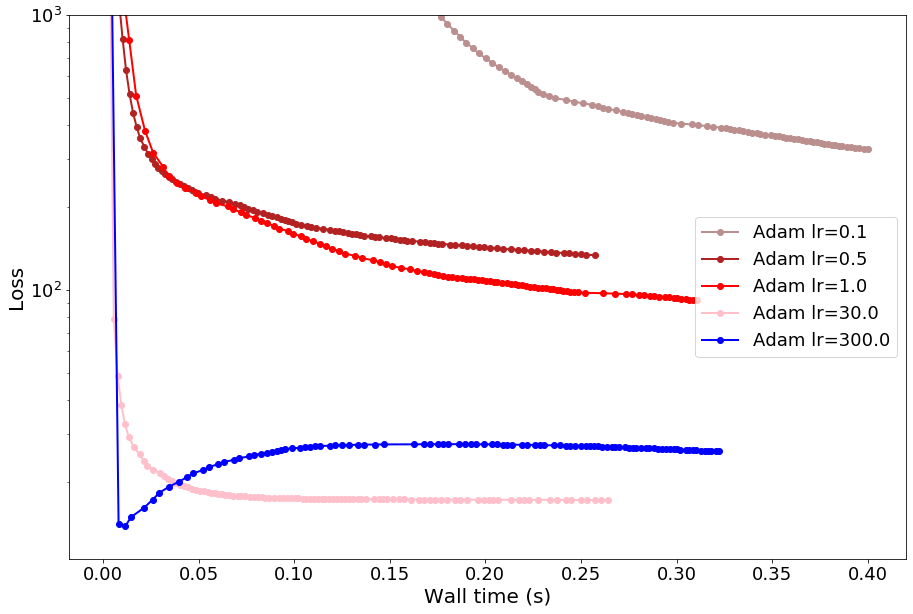

In [24]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
colors = ['rosybrown', 'firebrick', 'red', 'pink','blue']
lrs = [0.1, 0.5, 1.0, 30., 300.]

names = [f'Adam lr={lr}' for lr in lrs]


res = [adam_iterations[lr] for lr in lrs]

for i, iterations in enumerate(res):
    ts = [itr.time for itr in iterations]
    fs = [itr.fun for itr in iterations]
    ax.semilogy(ts, fs, '.-', color=colors[i], lw=2, ms=12)

ax.legend(names, fontsize=18)
ax.set_ylim([0, 1000])
#ax.set_xlim([0, 1])
ax.set_ylabel('Loss', fontsize=20)
ax.set_xlabel('Wall time (s)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)

But if we use Adam with a learning rate of 3, it errors.

In [13]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X, Y, likelihood)
likelihood.train()
model.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

mll, adam_iterations[lr] = fit_torch(
    mll,
    optimizer_cls=torch.optim.Adam,
    lr=300.,
    track_iterations=True,
)

Iter 1/100: 3231.03515625
Iter 11/100: 21.570348739624023
Iter 21/100: 25.65089988708496
Iter 31/100: 27.09792137145996
Iter 41/100: 27.501100540161133
Iter 51/100: 27.471574783325195
Iter 61/100: 27.256996154785156
Iter 71/100: 26.957975387573242
Iter 81/100: 26.615554809570312
Iter 91/100: 26.246967315673828
Iter 100/100: 25.899463653564453


#### L-BFGS
L-BFGS does not require tuning the learning rate, but can take too large of steps early on while it is still learning the curvature. On this problem it fails when evaluating the closure for the first time.

In [14]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X, Y, likelihood)
likelihood.train()
model.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

mll, lbfgs_iterations = fit_lbfgs(mll, track_iterations=True)

../PyTorch-LBFGS/functions/LBFGS.py:259: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /tmp/pip-req-build-rc66hrpz/torch/csrc/utils/python_arg_parser.cpp:766.)
  p.data.add_(step_size, update[offset:offset + numel].view_as(p.data))


Iter 1/10: 6.4629974365234375
Iter 2/10: 6.4629974365234375
Iter 3/10: 6.462997913360596
Iter 4/10: 6.4629974365234375
Iter 5/10: 6.4629974365234375
Iter 6/10: 6.462998390197754
Iter 7/10: 6.462998390197754
Iter 8/10: 6.462997913360596
Iter 9/10: 6.4629974365234375
Iter 10/10: 6.4629974365234375
